# Generating virtual products


#### Install the Fractional Cover environment using the following on command line

In [1]:
'''
python3 -m venv ~/venvs/VP_Environment
source ~/venvs/VP_Environment/bin/activate
deactivate
realpath /env/lib/python3.10/site-packages > ~/venvs/VP_Environment/lib/python3.10/site-packages/base_venv.pth
source ~/venvs/VP_Environment/bin/activate
pip install --extra-index-url=https://packages.dea.ga.gov.au/ fc
pip install ephem
pip install --index-url https://packages.dea.ga.gov.au/ wofs
python -m ipykernel install --user --name=VP_Environment
cd venvs/VP_Environment
touch setup.py

##### add in text below to setup.py

from setuptools import setup, find_packages

setup(
    name='VP_Environment',
    version='1.0',
    packages=find_packages(),
    install_requires=[
        'ephem',
        'wofs',
        'fc'
    ],
)

#####

python setup.py bdist_egg

'''

"\npython3 -m venv ~/venvs/VP_Environment\nsource ~/venvs/VP_Environment/bin/activate\ndeactivate\nrealpath /env/lib/python3.10/site-packages > ~/venvs/VP_Environment/lib/python3.10/site-packages/base_venv.pth\nsource ~/venvs/VP_Environment/bin/activate\npip install --extra-index-url=https://packages.dea.ga.gov.au/ fc\npip install ephem\npip install --index-url https://packages.dea.ga.gov.au/ wofs\npython -m ipykernel install --user --name=VP_Environment\ncd venvs/VP_Environment\ntouch setup.py\n\n##### add in text below to setup.py\n\nfrom setuptools import setup, find_packages\n\nsetup(\n    name='VP_Environment',\n    version='1.0',\n    packages=find_packages(),\n    install_requires=[\n        'ephem',\n        'wofs',\n        'fc'\n    ],\n)\n\n#####\n\npython setup.py bdist_egg\n\n"

#### Load packages

In [2]:
%matplotlib inline
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import os, sys
sys.path.insert(1, "/home/jovyan/code/livingearth_png/le_plugins")
import datacube
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from datacube.utils.cog import write_cog
from odc.algo import to_f32, xr_geomedian, int_geomedian

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map

from datacube.drivers.netcdf import write_dataset_to_netcdf

# for virtual products
import yaml
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER

dc = datacube.Datacube(app='Virtual_products')

catalog = catalog_from_file('../le_plugins/virtual_product_cat.yaml')


#### AWS Access

In [3]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True)#, client=client);

#### display AOI

In [4]:
# latitude = (-7.3, -7.31)
# longitude = (144.4, 144.41)

latitude = (-7.3, -7.4)
longitude = (144.4, 144.5)
display_map(longitude, latitude)

#### Set query

In [5]:
time = ('2020-01-01', '2020-03-31')

crs = "EPSG:32755"
res = (30, -30)

query =({'time': time,
             'latitude':latitude,
            'longitude':longitude,
            'output_crs':crs,
            'resolution':res})

## Load virtual products

In [6]:
list(catalog)

['ls_8', 'geomedian', 'fractional_cover', 'DEM', 'WOfS', 'mangroves']

### Landsat 8

In [7]:
# Landsat 8
product = catalog['ls_8']
ls_8 = product.load(dc, **query)

In [8]:
ls_8

<xarray.Dataset>
Dimensions:      (time: 6, y: 372, x: 371)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-09T00:32:21.351495 ... 2020-03...
  * y            (y) float64 9.181e+06 9.181e+06 ... 9.192e+06 9.192e+06
  * x            (x) float64 2.24e+05 2.24e+05 2.24e+05 ... 2.13e+05 2.129e+05
    spatial_ref  int32 32755
Data variables:
    blue         (time, y, x) uint16 8670 8152 7940 8943 ... 16035 13309 12281
    green        (time, y, x) uint16 9802 9388 9571 10377 ... 18294 15928 14650
    red          (time, y, x) uint16 9291 8831 9060 9783 ... 18338 15929 14968
    nir08        (time, y, x) uint16 18198 17900 18005 ... 26093 24374 23812
    swir16       (time, y, x) uint16 11278 11083 11214 ... 20475 19359 18821
    swir22       (time, y, x) uint16 9387 9236 9399 9968 ... 17220 16250 15886
    qa_pixel     (time, y, x) uint16 24082 24082 23888 ... 22280 22280 22280
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

### Geomedian

In [9]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "geomedian"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [10]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

{'make_mask': datacube.virtual.transformations.MakeMask,
 'apply_mask': datacube.virtual.transformations.ApplyMask,
 'to_float': datacube.virtual.transformations.ToFloat,
 'rename': datacube.virtual.transformations.Rename,
 'select': datacube.virtual.transformations.Select,
 'expressions': datacube.virtual.transformations.Expressions,
 'geomedian': geomedian.geomedian}

In [11]:
# load geomedian
product = catalog['geomedian']
geomedian = product.load(dc, **query)

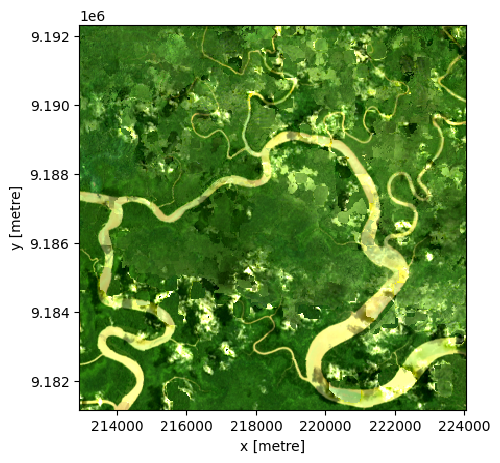

In [12]:
# Plot the result
rgb(geomedian, size=5)

### Fractional Cover

In [13]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "fractional_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [14]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

{'make_mask': datacube.virtual.transformations.MakeMask,
 'apply_mask': datacube.virtual.transformations.ApplyMask,
 'to_float': datacube.virtual.transformations.ToFloat,
 'rename': datacube.virtual.transformations.Rename,
 'select': datacube.virtual.transformations.Select,
 'expressions': datacube.virtual.transformations.Expressions,
 'geomedian': geomedian.geomedian,
 'fractional_cover': fractional_cover.fractional_cover}

In [15]:
# load geomedian
product = catalog['fractional_cover']
fractional_cover = product.load(dc, **query)

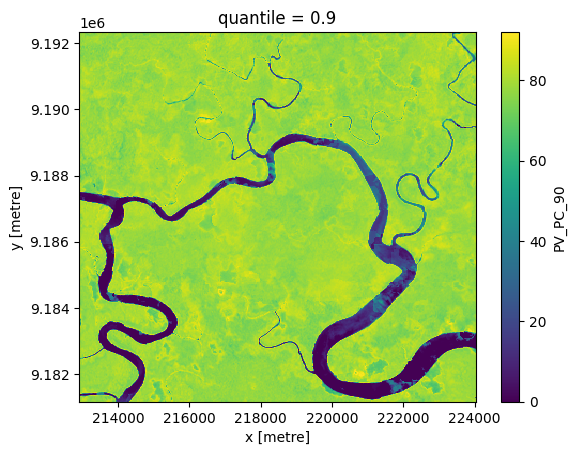

In [16]:
fractional_cover.PV_PC_90.plot()

### WOfS

In [17]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "WOfS"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [18]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

{'make_mask': datacube.virtual.transformations.MakeMask,
 'apply_mask': datacube.virtual.transformations.ApplyMask,
 'to_float': datacube.virtual.transformations.ToFloat,
 'rename': datacube.virtual.transformations.Rename,
 'select': datacube.virtual.transformations.Select,
 'expressions': datacube.virtual.transformations.Expressions,
 'geomedian': geomedian.geomedian,
 'fractional_cover': fractional_cover.fractional_cover,
 'WOfS': WOfS.WOfS}

In [19]:
# wofs
product = catalog['WOfS']
wofs = product.load(dc, **query)

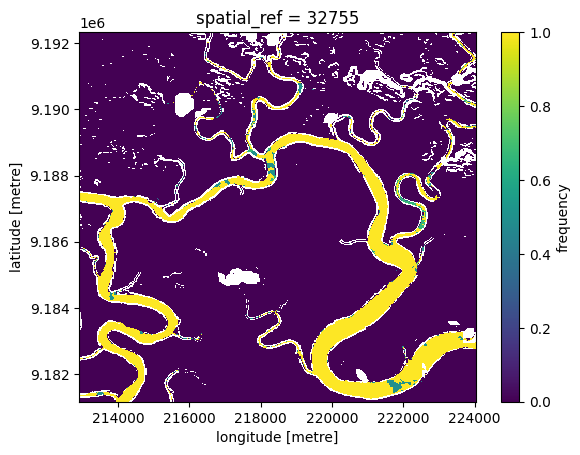

In [20]:
wofs.frequency.plot()

### Need outputs? - change below as required

In [21]:
# # add crs and to_array for cog output
# geomedian.attrs['crs'] = 'EPSG:32755'
# geomedian_export = geomedian.to_array()

# # output as cog
# write_cog(geomedian_export, '../data/geomedian_test.tif', overwrite=True)

# # export out as .nc to allow load back in easily as xarray
# write_dataset_to_netcdf(geomedian, '../data/geomedian_test.nc')